

   # TIC 470171739  
   # TOI 4153 


## Known Parameters taken from:
### https://exofop.ipac.caltech.edu/tess/target.php?id=470171739


### Web TESS Viewing Tool
### https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py?Entry=470171739


#### This code uses observational data from the CRCAO and a log likely hood probability funtion to approzimate unknown parameters. 

In [46]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas
import pandas as pd
import batman
import emcee as mc
import corner as corn
from astropy.time import Time

In [47]:

# Import CSV Data file (x, y, err):   38846515.csv 
FILE = "C:/Users/zraup/OneDrive/Desktop/Conferences_Astro/AAS/Data/TOI_4153/470171739b.csv"
data = pd.read_csv(FILE, delim_whitespace=False, header = 0).to_numpy()
#print(data)

In [48]:

# Ephemeris for TOI 470171739
# Data from CRCAO observations

P = 4.617          # Period (days)
T0 = 2459838.72      # Epoch (BJD)

# From data file
TJD = data[:,0]       
flux_n = data[:,1]
Error= data[:,2]
BJD = TJD + 2457000

# Predicted TTF ingress and egress
ing_TTF = 2459838.6277                   # BJD
egr_TTF = 2459838.8136                   # BJD
T0_TTF = 2459838.7206 

#print(BJD)

In [65]:

# Log likelyhood funtion Probability
def logp(freeparams, BJD):
   
    # Parameters (Set free parameters(unknown) and fixed(known))           
    rplanetRearth = freeparams[0]        # ExoFop 17.5913
    rstarRsun = 1.672                    # ExoFop 1.672
    mstarMsun = 1.289                    # ExoFop 1.289
    ainAU = (P/365.25)**(2./3.)*mstarMsun**(1./3.)   ## Kep 3rd Law
    params = batman.TransitParams()
    params.t0 = freeparams[1] #         CRCAO 2458572.8549           # time of inferior conjunction
    b = freeparams[2]    #free # 0.25 # 0.45  # 0.99             # impact parameter 
    params.per = P                             # orbital period
    params.rp = rplanetRearth/rstarRsun/110.             # planet radius (in units of stellar radii)
    params.a = ainAU*215/rstarRsun                  # semi-major axis (in units of stellar radii)
    params.inc = 180*np.arccos(b/params.a)/np.pi         # orbital inclination (in degrees)
    params.ecc = 0.00            ######                  # eccentricity
    params.w = 90.0              ######                  # longitude of periastron (in degrees)
    params.u = [0.3, 0.3]  # [freeparams[6], freeparams[7]] #   [0.1, 0.0]       ######             #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       
    
    # Set-Up Model using Batman transit modeler
    mc = batman.TransitModel(params, BJD)                 # initializes model
    flux_mc = mc.light_curve(params)                         # model of flux
    
    # Calculate difference between data and model
    dif_mc = data[:,1] - flux_mc
    
    
# Set restrictions for paramters   
    # Do not allow b to be less than 0 or greater than 1
    if b < 0: 
        return -1*np.inf
    if b > 1:
        return -1*np.inf
    
    # Do not allow e to be less than 0 or greater than 1
    if params.ecc < 0: 
        return -1*np.inf
    if params.ecc > 1:
        return -1*np.inf
    
    # Do not allow e to be less than 0 or greater than 1
    if params.w < 0: 
        return -1*np.inf
    if params.w > 360:
        return -1*np.inf
    
    # Do not allow u to be less than 0 or greater than 1
    if params.u[0] < 0: 
        return -1*np.inf
    if params.u[0] > 1:
        return -1*np.inf

    if params.u[1] < 0: 
        return -1*np.inf
    if params.u[1] > 1:
        return -1*np.inf
    
    # Define log like funtion
    loglike = -0.5 * np.sum(dif_mc**2 / data[:,2]**2)

    # Do not allow loglike to be (-)
    if loglike == loglike:
        return loglike
    else: 
        return -1*np.inf
    
  

In [66]:
# Set dimensions of sampler 
ndim = 3                                                # number of unknowns (free params)
nwalkers = 40 


In [67]:

# Set the initial parameter values for each walker:
r0 = [16.16, T0, 0.56]           # Set initial values for walkers

# Set starting point for each walker
Rp0_walker = r0[0] + 1e-3 * np.random.randn(nwalkers)    # walkers for Period # (days)
T0_walker = r0[1] + 1e-3 * np.random.randn(nwalkers)    # walkers for T0 #  (BJD)
b0_walker = r0[2] + 1e-3 * np.random.randn(nwalkers)


r0 = np.transpose([Rp0_walker, T0_walker, b0_walker])   # u10_walker, u20_walker])


In [68]:
# Initialize the Sampler
sampler = mc.EnsembleSampler(nwalkers, ndim, logp, args=[BJD])

In [69]:
# Run the Sampler:
state = sampler.run_mcmc(r0, 2500, progress = True)     # sampler.run_mcmc(initial values, number of itierations)
r = sampler.get_chain(flat=True, discard= 500)

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:13<00:00, 179.75it/s]


In [70]:

# Calculate Median & Confidence Interval


# Best fit for T0 and +/- %68 Confidence level
best_fit_Rp = np.median(r[:,0])
CI_68_Rp = np.percentile(r[:,0], 15.9) , np.percentile(r[:,0], 84.2)

uncert_Rp_plus = np.abs(CI_68_Rp[1] - best_fit_Rp)
uncert_Rp_neg = np.abs(CI_68_Rp[0] - best_fit_Rp)
uncert_Rp = [uncert_Rp_plus, uncert_Rp_neg]

# Best fit for Period and +/- %68 Confidence level
best_fit_T0 = np.median(r[:,1])
CI_68_T0 = np.percentile(r[:,1], [15.9, 84.2])

uncert_T0_plus = np.abs(CI_68_T0[1] - best_fit_T0) 
uncert_T0_neg = np.abs(CI_68_T0[0] - best_fit_T0) 
uncert_T0 = [uncert_T0_plus, uncert_T0_neg]

# Best fit for Period and +/- %68 Confidence level
best_fit_b = np.median(r[:,2])
CI_68_b = np.percentile(r[:,2], [15.9, 84.2])

uncert_b_plus = np.abs(CI_68_b[1] - best_fit_b) 
uncert_b_neg = np.abs(CI_68_b[0] - best_fit_b) 
uncert_b = [uncert_b_plus, uncert_b_neg]


In [71]:
# Print Mean & Std
print(' ')
print('     Parameter Values')
print(' ')
print(' Period (days) =', best_fit_Rp, ' Uncertantity +/- =', uncert_Rp,'   %68 Confidence Interval limits =', CI_68_Rp)
print(' ')
print(' T0 (BJD) =', best_fit_T0, ' Uncertantity +/- =', uncert_T0, '   %68 Confidence Interval limits =', CI_68_T0)
print(' ')
print(' impact parameter =', best_fit_b, ' Uncertantity +/- =', uncert_b, '   %68 Confidence Interval limits =', CI_68_b)
print(' ')

 
     Parameter Values
 
 Period (days) = 16.658553229216082  Uncertantity +/- = [0.5083096377374083, 0.49238768721892257]    %68 Confidence Interval limits = (16.16616554199716, 17.16686286695349)
 
 T0 (BJD) = 2459838.7157859607  Uncertantity +/- = [0.0023291311226785183, 0.002421949990093708]    %68 Confidence Interval limits = [2459838.71336401 2459838.71811509]
 
 impact parameter = 0.5931773683541695  Uncertantity +/- = [0.037407369306414084, 0.03771988618980715]    %68 Confidence Interval limits = [0.55545748 0.63058474]
 


In [72]:

# Create model using median values
rplanetRearth = best_fit_Rp          # ExoFop 17.5913
rstarRsun = 1.672                    # ExoFop 1.672
mstarMsun = 1.289                    # ExoFop 1.289
ainAU = (P/365.25)**(2./3.)*mstarMsun**(1./3.)   ## Kep 3rd Law
params = batman.TransitParams()
params.t0 = best_fit_T0 #         CRCAO 2458572.8549           # time of inferior conjunction
b = best_fit_b    #free # 0.25 # 0.45  # 0.99             # impact parameter 
params.per = P                             # orbital period
params.rp = rplanetRearth/rstarRsun/110.             # planet radius (in units of stellar radii)
params.a = ainAU*215/rstarRsun                  # semi-major axis (in units of stellar radii)
params.inc = 180*np.arccos(b/params.a)/np.pi         # orbital inclination (in degrees)
params.ecc = 0.00            ######                  # eccentricity
params.w = 90.0              ######                  # longitude of periastron (in degrees)
params.u = [0.3, 0.3]  # [freeparams[6], freeparams[7]] #   [0.1, 0.0]       ######             #limb darkening coefficients [u1, u2]
params.limb_dark = "quadratic" 

print(params.inc, params.a)


# Create model using batman # median values
bm = batman.TransitModel(params, BJD)         #initializes model
flux_b = bm.light_curve(params)   


# Calculate the difference in   
dif = data[:,1] - flux_b

phi = (BJD - params.t0) / P
phi -= np.floor(phi)

mask = phi > 0.5
phi[mask] -= 1

85.51994259546352 7.593924224185106


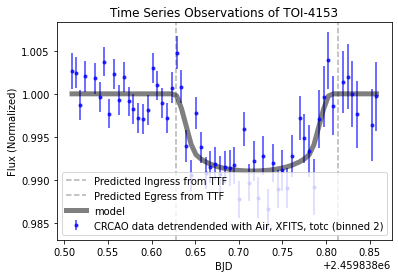

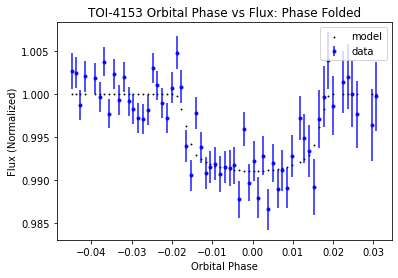

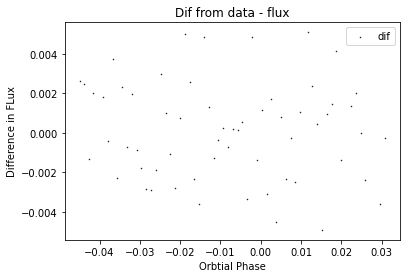

In [73]:

# Plot scatter plot with model and data (BJD vs flux)
plt.errorbar(BJD, data[:,1], data[:,2], fmt='.', color = 'blue', alpha = 0.75, label = 'CRCAO data detrendended with Air, XFITS, totc (binned 2)')
plt.axvline(ing_TTF, color = 'black', linestyle = '--', alpha= 0.3, label = 'Predicted Ingress from TTF')
plt.axvline(egr_TTF, color = 'black', linestyle = '--', alpha= 0.3, label = 'Predicted Egress from TTF')
plt.plot(BJD, flux_b, linewidth = 5, color = 'black', alpha = 0.5, label = 'model')
plt.title('Time Series Observations of TOI-4153')
plt.xlabel('BJD')
plt.ylabel('Flux (Normalized)')
plt.legend()
plt.show()

# Plot scatter plot with model and data #PHASE FOLDED# (orbital phase vs flux)
plt.errorbar(phi, data[:,1], data[:,2], fmt='.', color = 'blue', alpha = 0.9, label = 'data')
plt.scatter(phi, flux_b, color = 'black', s= 0.9, alpha = 0.9, label = 'model')
plt.title('TOI-4153 Orbital Phase vs Flux: Phase Folded')
plt.xlabel('Orbital Phase')
plt.ylabel('Flux (Normalized)')
plt.legend()
plt.show()

# Plot time vs the difference of flux of the raw data points and the model
plt.scatter(phi, dif, color = "black", label = 'dif', s= 0.25)
plt.title('Dif from data - flux')
plt.xlabel('Orbtial Phase')
plt.ylabel('Difference in FLux')
plt.legend()
plt.show()

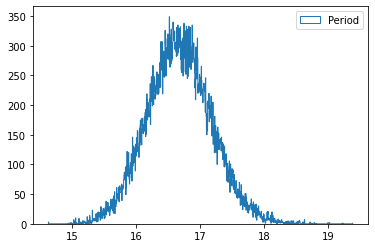

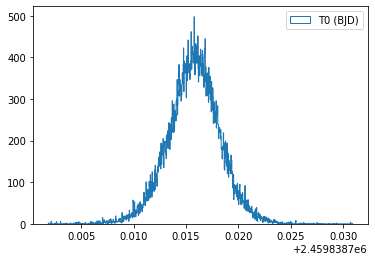

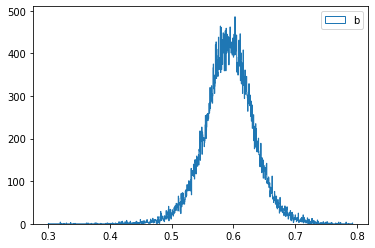

In [74]:

# Plot Histograms

# Histogram of Period estimated values (days)
plt.hist(r[:,0], 1000, histtype= 'step', label = ('Period'))
plt.legend()
plt.savefig('Period_hist.png')
plt.show()

# Histogram of T0 estimated values (BJD)
plt.hist(r[:,1], 1000, histtype= 'step', label = ('T0 (BJD)'))
plt.legend()
plt.show()

# Histogram of b estimated values 
plt.hist(r[:,2], 1000, histtype= 'step', label = ('b'))
plt.legend()
plt.show()

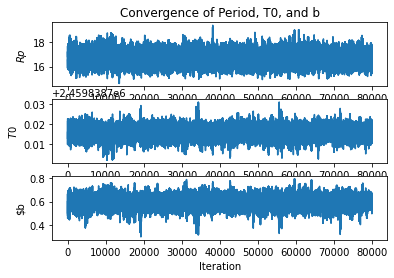

In [75]:

# Plot the convergence for each parameter:
fig, axes = plt.subplots(3)
axes[0].plot(r[:,0])
axes[1].plot(r[:,1])
axes[2].plot(r[:,2])
axes[+0].set_title('Convergence of Period, T0, and b')
axes[-1].set_xlabel('Iteration')
axes[0].set_ylabel(r'$Rp$')
axes[1].set_ylabel(r'$T0$')
axes[2].set_ylabel(r'$b')
plt.show()


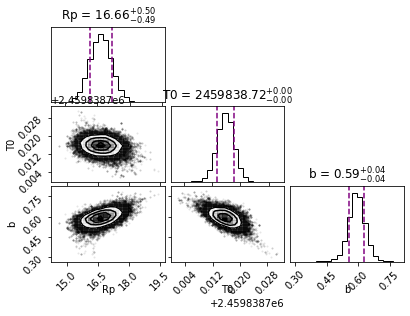

In [76]:

# Display results as "corner plt":
fig = plt.figure()
corn.corner(r, labels=['Rp', 'T0', 'b'], show_titles=True, fig=fig)

# Extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(np.percentile(r[:,i], 15.9), linestyle = '--', color="purple")
    ax.axvline(np.percentile(r[:,i], 84.2), linestyle = '--', color="purple")
plt.show()